# **Tutorial 6: Compute and Plot Temperature Anomalies**

**Week 1, Day 1, Climate System Overview**

**Content creators:** Sloane Garelick, Julia Kent

**Content reviewers:** Katrina Dobson, Younkap Nina Duplex, Danika Gupta, Maria Gonzalez, Will Gregory, Nahid Hasan, Sherry Mi, Beatriz Cosenza Muralles, Jenna Pearson, Agustina Pesce, Chi Zhang, Ohad Zivan

**Content editors:** Jenna Pearson, Chi Zhang, Ohad Zivan

**Production editors:** Wesley Banfield, Jenna Pearson, Chi Zhang, Ohad Zivan

**Our 2023 Sponsors:** NASA TOPS

# **Tutorial Objectives**
In the previous tutorials, we have explored global climate patterns and processes, focusing on the terrestrial atmospheric and oceanic climate systems. We have understood that Earth's energy budget, primarily controlled by incoming solar radiation, plays a crucial role in shaping Earth's climate. In addition to these factors, there are other significant long-term climate forcings that can influence global temperatures. To gain insight into these forcings, we need to look into historical temperature data, as it offers valuable context for understanding these climatic influences.

Recent and future temperature change is often presented as an anomaly relative to a past climate state or historical period. For example, past and future temperature changes relative to pre-industrial average temperature is a common comparison. 

In this tutorial, our objective is to deepen our understanding of these temperature anomalies. We will compute and plot the global temperature anomaly from 2000-01-15 to 2014-12-1, providing us with a clearer perspective on recent climatic changes.

# Setup


In [10]:
# !pip install matplotlib.pyplot
# !pip install numpy
# !pip install xarray
# !pip install pythia_datasets
# !pip install pandas

In [1]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from pythia_datasets import DATASETS
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# @title Figure Settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/ClimateMatchAcademy/course-content/main/cma.mplstyle")

In [3]:
# @title Video 1: Video Title
#Tech team will add code to format and display the video

Let's load the same data that we used in the previous tutorial (monthly SST data from CESM2):

In [4]:
filepath = DATASETS.fetch('CESM2_sst_data.nc')
ds = xr.open_dataset(filepath)
ds

C:\ProgramData\Anaconda3\envs\climatematch_test\lib\site-packages\xarray\conventions.py:427: SerializationWarning: variable 'tos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


<xarray.Dataset>
Dimensions:    (time: 180, d2: 2, lat: 180, lon: 360)
Coordinates:
  * time       (time) object 2000-01-15 12:00:00 ... 2014-12-15 12:00:00
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon        (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
Dimensions without coordinates: d2
Data variables:
    time_bnds  (time, d2) object ...
    lat_bnds   (lat, d2) float64 ...
    lon_bnds   (lon, d2) float64 ...
    tos        (time, lat, lon) float32 ...
Attributes: (12/45)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   674885.0
    branch_time_in_parent:  219000.0
    case_id:                972
    ...                     ...
    sub_experiment_id:      none
    table_id:               Omon
    tracking_id:            hdl:21.14100/2975ffd3-1d7b-47e3-961a-33f212ea4eb2
    variable_id:            tos
    variant_info:           CMIP6 20th century experiments (1850-2014) with C...
    variant_label:          r11i1p1f1

# Section 1: Compute anomaly

First, we'll compute climatology using xarray's `groupby` operation to split the SST data by month. Then, we'll remove this climatology from our original data:

In [5]:
gb = ds.tos.groupby('time.month')
tos_anom = gb - gb.mean(dim='time')
tos_anom

<xarray.DataArray 'tos' (time: 180, lat: 180, lon: 360)>
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [-0.01402271, -0.01401699, -0.01401365, ..., -0.01406252,
         -0.01404929, -0.01403356],
        [-0.01544118, -0.01544452, -0.01545036, ..., -0.01544762,
         -0.01544333, -0.01544082],
        [-0.01638114, -0.01639009, -0.01639986, ..., -0.01635301,
         -0.01636171, -0.01637125]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
...
        [ 0.01727951,  0.01713443,  0.01698065, ...,  0.0176847 ,
          0.01755834,  0.01742125],
        [ 0.01738632,  0.01729178,  0.01719618, ...,  0.01766801,
          0.01757407,  0.01748013],
        [ 0.01693726,  0.01687264,  0.01680505, ...,  0.01709175,
          0.01704252,  0.01699162]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [ 0.01506376,  0.01491845,  0.01476002, ...,  0.0154525 ,
          0.0153321 ,  0.0152024 ],
        [ 0.0142287 ,  0.01412642,  0.0140208 , ...,  0.01452136,
          0.01442564,  0.01432812],
        [ 0.01320827,  0.01314461,  0.01307786, ...,  0.0133611 ,
          0.01331258,  0.01326215]]], dtype=float32)
Coordinates:
  * time     (time) object 2000-01-15 12:00:00 ... 2014-12-15 12:00:00
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

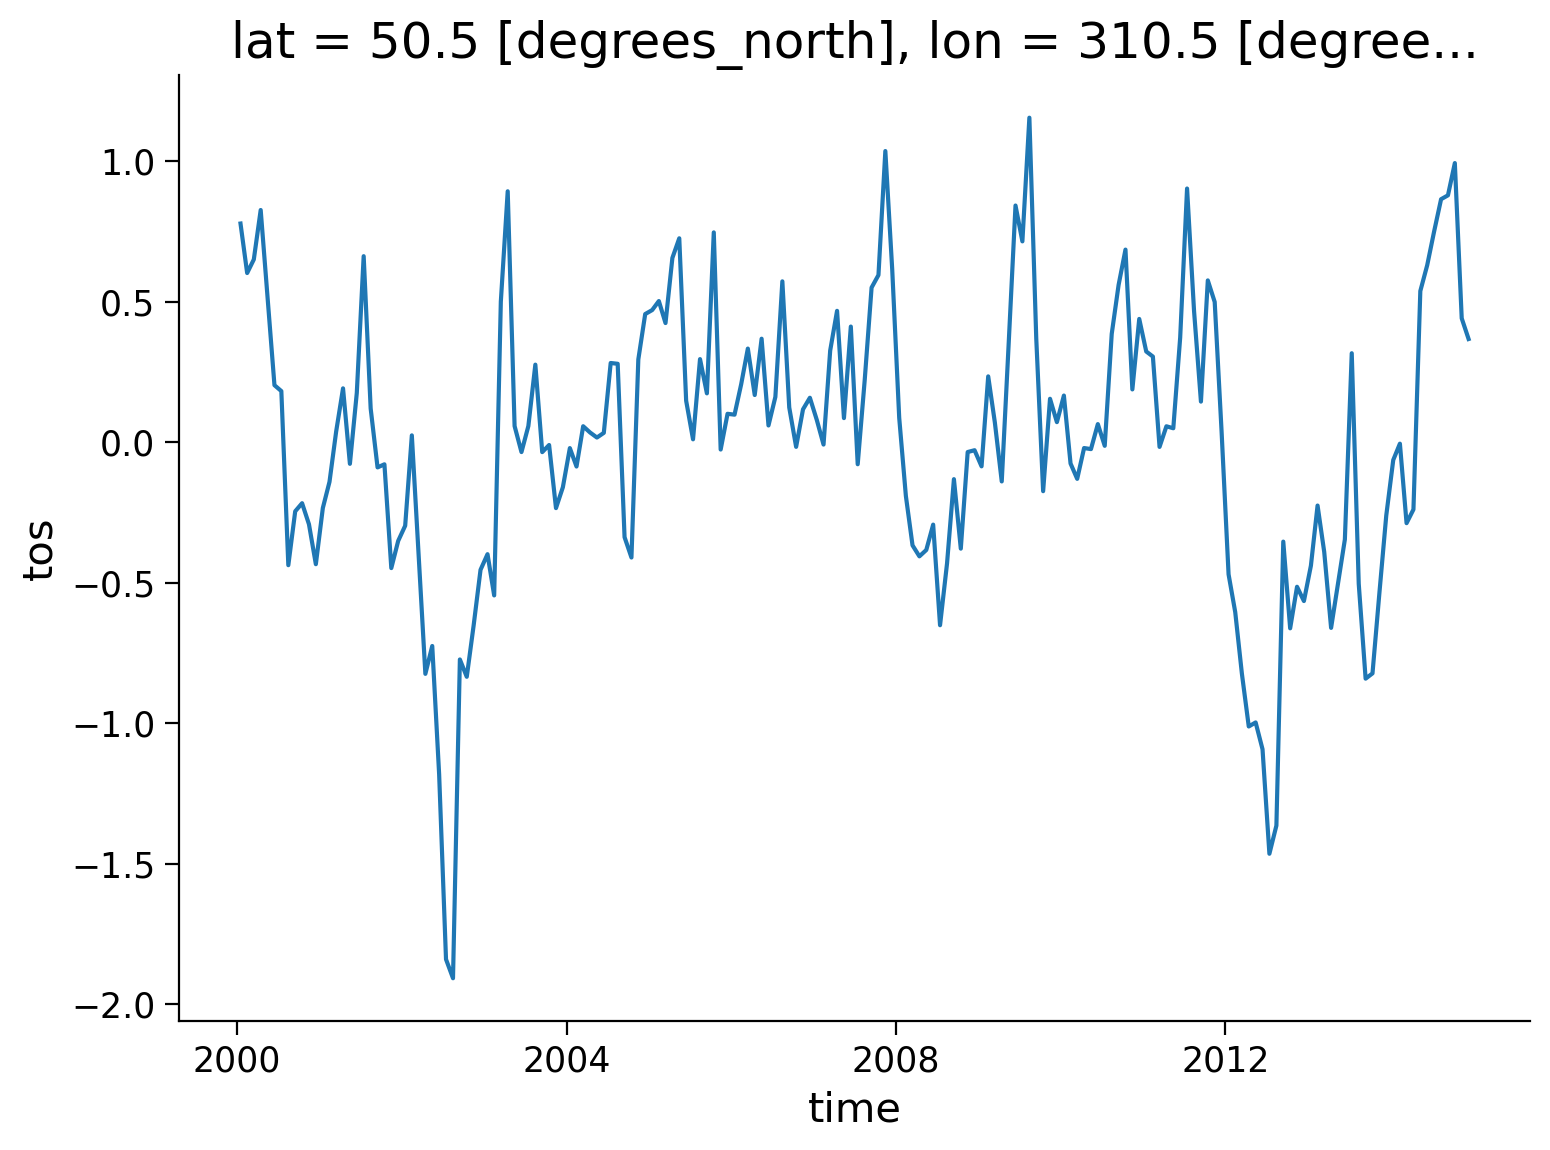

In [6]:
tos_anom.sel(lon=310, lat=50, method='nearest').plot();

Next, let's compute and visualize the mean global anomaly over time. We need to specify both `lat` and `lon` dimensions in the `dim` argument to `mean()`:

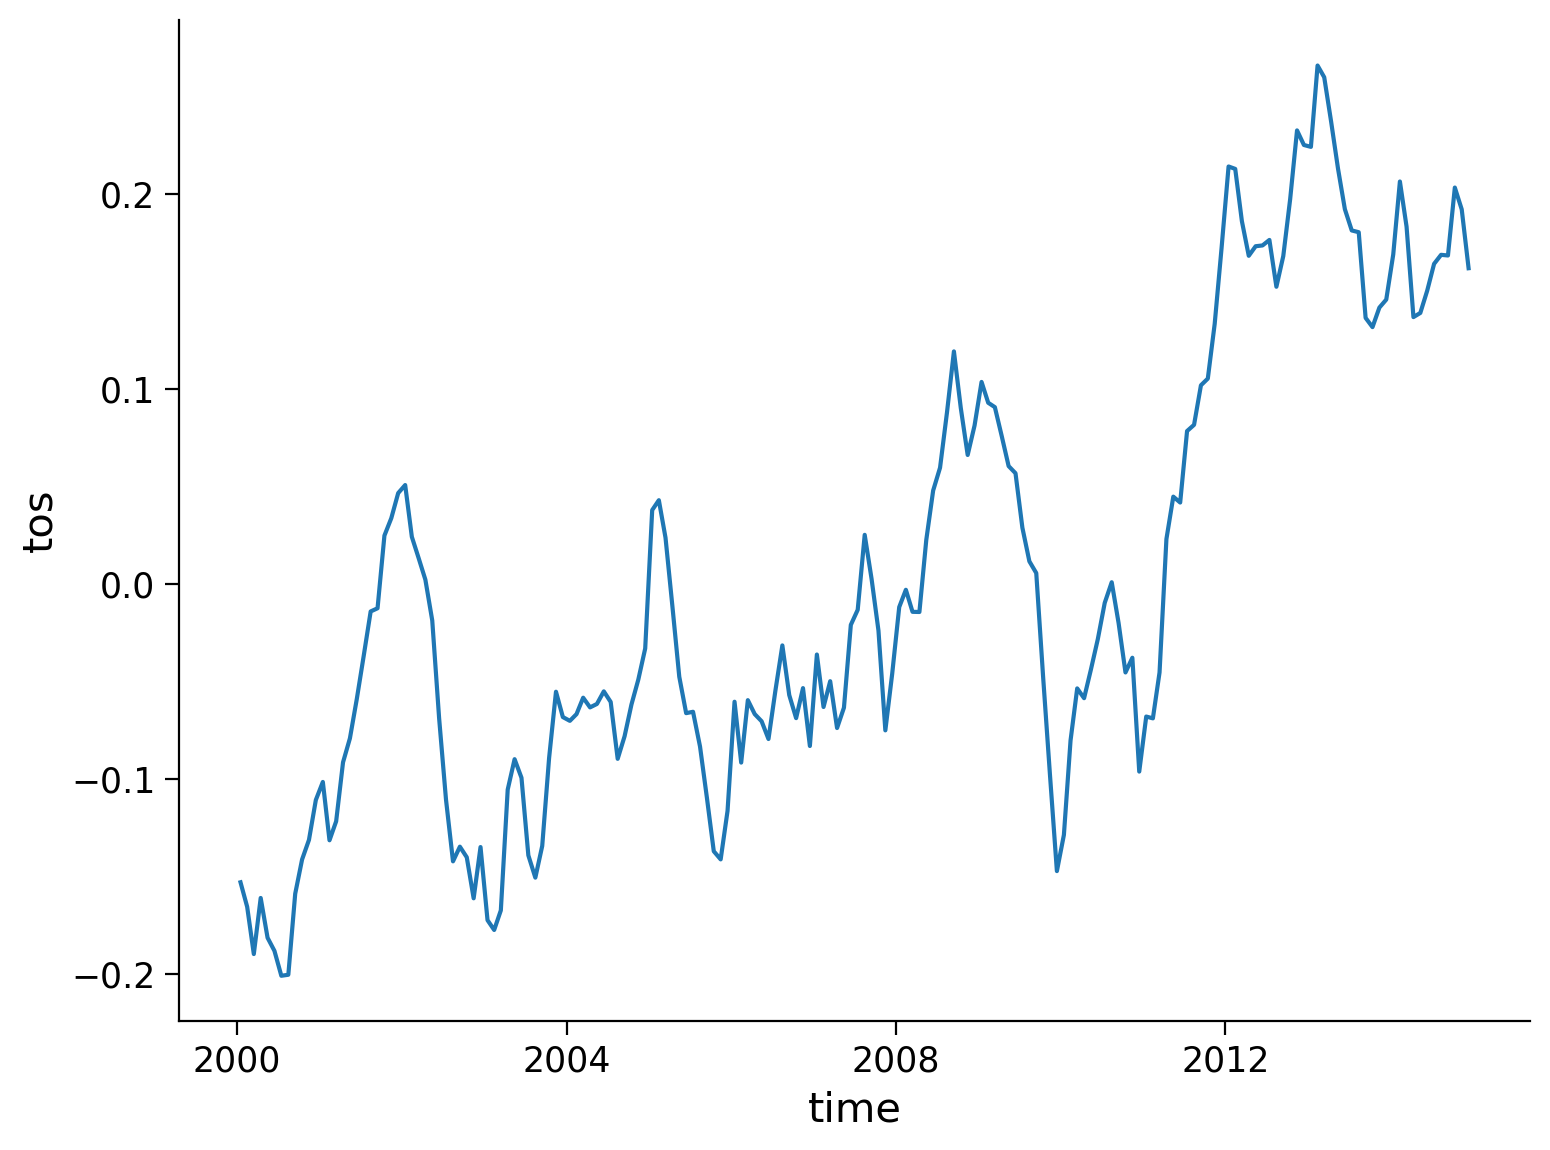

In [7]:
unweighted_mean_global_anom = tos_anom.mean(dim=['lat', 'lon'])
unweighted_mean_global_anom.plot();

Notice that we called our variable `unweighted_mean_global_anom`. Next, we are going to compute the  `weighted_mean_global_anom`. Why do we need to weight our data? Grid cells with the same range of degrees latitude and longitude is not necessarily same size. Specifically, grid cells closer to the equator are much larger than those near the poles, as seen in the figure below (Djexplo, 2011, CC-BY). 

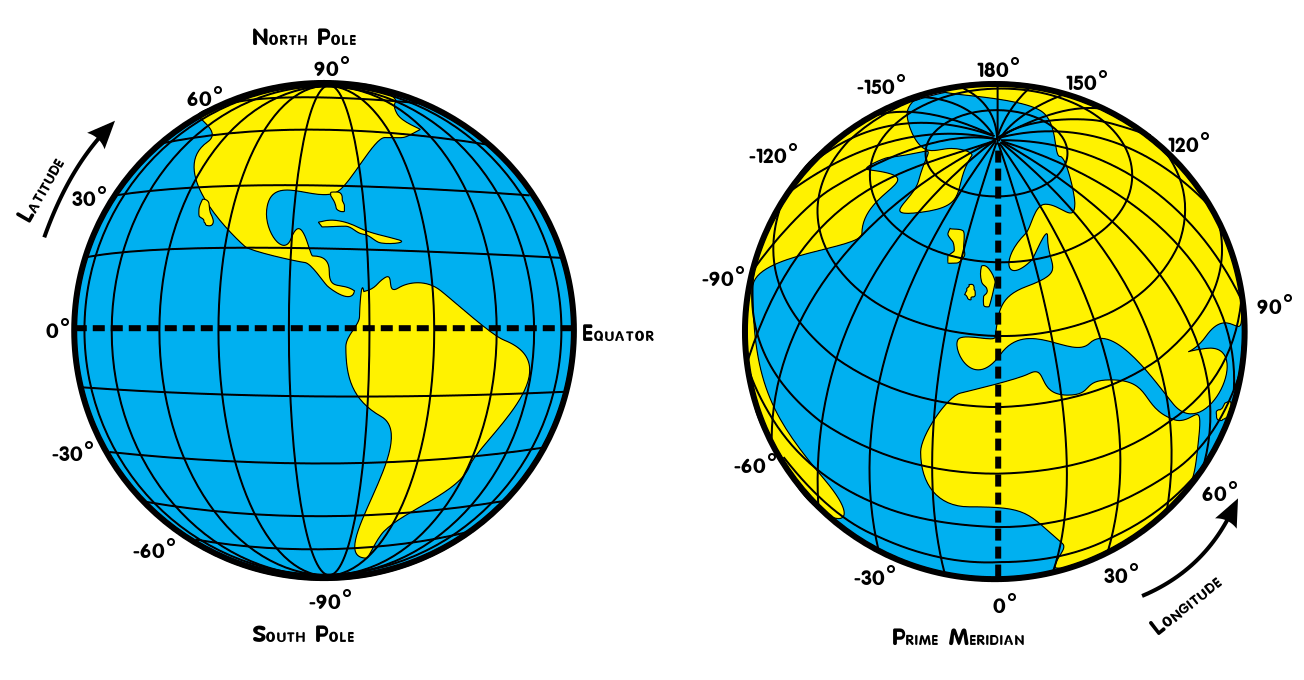

Therefore, an operation which combines grid cells of different size is not scientifically valid unless each cell is weighted by the size of the grid cell. Xarray has a convenient [`.weighted()`](https://xarray.pydata.org/en/stable/user-guide/computation.html#weighted-array-reductions) method to accomplish this.

Let's first load the grid cell area data from another CESM2 dataset that contains the weights for the grid cells:

In [8]:
filepath2 = DATASETS.fetch('CESM2_grid_variables.nc')
areacello = xr.open_dataset(filepath2).areacello
areacello

<xarray.DataArray 'areacello' (lat: 180, lon: 360)>
[64800 values with dtype=float64]
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
Attributes: (12/17)
    cell_methods:   area: sum
    comment:        TAREA
    description:    Cell areas for any grid used to report ocean variables an...
    frequency:      fx
    id:             areacello
    long_name:      Grid-Cell Area for Ocean Variables
    ...             ...
    time_label:     None
    time_title:     No temporal dimensions ... fixed field
    title:          Grid-Cell Area for Ocean Variables
    type:           real
    units:          m2
    variable_id:    areacello

As before, let's calculate area-weighted mean global anomaly:

In [9]:
weighted_mean_global_anom = tos_anom.weighted(areacello).mean(dim=['lat', 'lon'])

Let's plot both unweighted and weighted means:

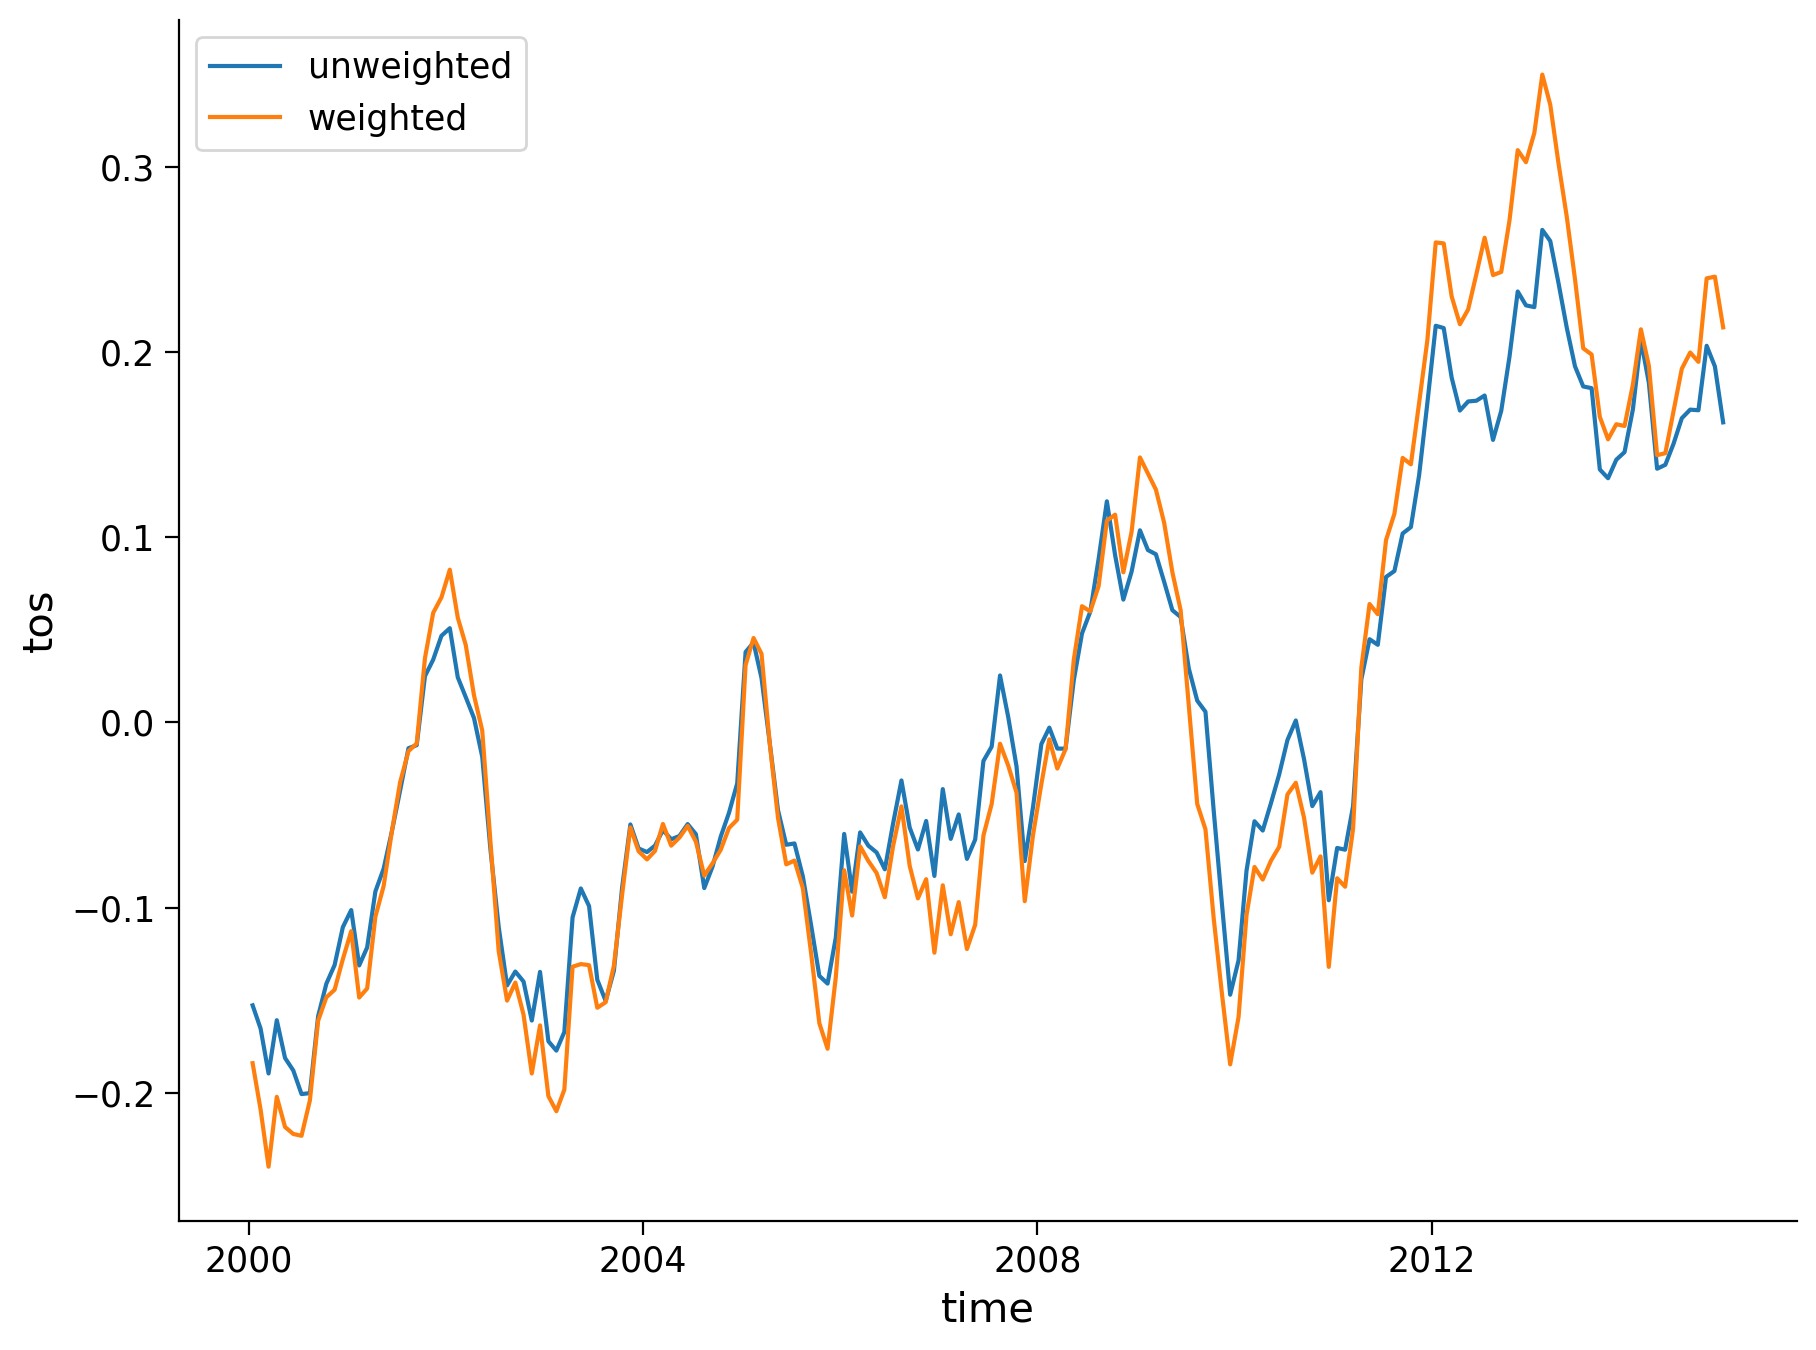

In [10]:
unweighted_mean_global_anom.plot(size=7)
weighted_mean_global_anom.plot()
plt.legend(['unweighted', 'weighted']);

# Section 2: Climate Connection 

- What is the significance of calculating area-weighted mean global temperature anomalies when assessing climate change? How are the weighted and unweighted SST means similar and different? 
- What overall trends do you observe in the global SST mean over this time? How does this magnitude and rate of temperature change compare to past temperature variations on longer timescales (refer back to the figures in the video)?


In [11]:
# to_remove explanation

"""
1. An area-weighted mean global temperature anomaly provides a more accurate representation of global temperature changes by accounting for the uneven distribution of grid cell sizes across latitudes. It ensures each region's contribution to the global mean is proportional to its surface area, avoiding any disproportionate influence from smaller areas at higher latitudes. Both weighted and unweighted SST means show the similar increase trend.
2. The observed SST warming trend from 2000 to 2014 is similar to the rate of change observed from 1980 to 2000, which fits into the larger context of the substantial warming trend observed over the past century. Over this period, global average temperatures have risen unprecedently. 
"""

"\n1. An area-weighted mean global temperature anomaly provides a more accurate representation of global temperature changes by accounting for the uneven distribution of grid cell sizes across latitudes. It ensures each region's contribution to the global mean is proportional to its surface area, avoiding any disproportionate influence from smaller areas at higher latitudes. Both weighted and unweighted SST means show the similar increase trend.\n2. The observed SST warming trend from 2000 to 2014 is similar to the rate of change observed from 1980 to 2000, which fits into the larger context of the substantial warming trend observed over the past century. Over this period, global average temperatures have risen unprecedently. \n"

## Summary

In this tutorial, we focused on historical temperature changes. We computed and plotted the global temperature anomaly from 2000 to 2014. This helped us enhance our understanding of recent climatic changes and their potential implications for the future.




# Resources

## **Code and Data Sources**

Code and data for this tutorial is based on existing content from [Project Pythia](https://foundations.projectpythia.org/core/xarray/computation-masking.html).